# https://github.com/must4in3/pix2pix

In [1]:
import tensorflow as tf
#import os
#import time
from matplotlib import pyplot as plt
#from IPython import display
from src.generator_functions import downsample, upsample, Generator, generator_loss
from src.Image_processing_functions import load
from src.discriminator_functions import Discriminator

In [2]:
inp, re = load('inputs/images/pix2pix_input1.jpg')

# Generator

**Build the Generator <br>
The architecture of generator is a modified U-Net.<br>**
U-Net is a convolutional neural network that was developed for biomedical image segmentation at the Computer Science Department of the University of Freiburg, Germany.[1] The network is based on the fully convolutional network[2] and its architecture was modified and extended to work with fewer training images and to yield more precise segmentations. Segmentation of a 512 × 512 image takes less than a second on a modern GPU.<br>
**Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)**<br>
A starting image can be transformed by obtaining a particular effect by applying a convolution mask to it. Think of the convolution operation as the application of a filter on any computer graphics program, where the filters themselves are the convolution masks.<br>
Convolution masks can be interpreted as feature detectors, that is, as tools that allow us to understand the details of an image, such as how red there is, how many and what are the sources of light or how the contrast ratio is . <br>
If we take an input image and apply a certain convolution mask to it, we could obtain a result image in which the functionality we want to analyze is isolated.<br>
**Batch Normalizacion**<br>
It is used to speed up the training of neural networks and improve their performance.<br>
The intuition from which the BN is born is quite simple: the training of neural networks is slowed down by a phenomenon known as internal covariates shift.<br>
That is, during the training phase, the parameters of each sub-layer of the neural network are optimized, so that the final error produced by the network is minimized, iteration after iteration<br>
Changing the inputs to each layer represents a problem because the layers of the network must continually adapt to a new distribution of the input values, therefore, to improve the training phase, it is necessary to fix this distribution.<br>
The solution is to normalize the network inputs to each sub-layer of the network itself (it is called Batch Normalization).<br>
**ReLU**<br>
In the context of artificial neural networks, the ReLU is an activation function
**Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)<br>
**Transposed Con** <br>
When we transpose convolutions, we change the order of dimensions in this matrix of convolution operations, which has some interesting effects and leads to different behaviors than the regular convolutions of which we have learned so far.<br>
**dropout**<br>
Yhis technique involves applying the usual procedure by first removing a certain percentage of neurons in each hidden layer! For each period of training you choose (randomly) which neurons to keep and which to discard and train the network thus obtained.. <br>
**There are skip connections between the encoder and decoder (as in U-Net).**<br>

In [3]:
down_model = downsample(3, 4)
# tf.expand_dims: Returns a tensor with an additional dimension inserted at index axis.
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [4]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


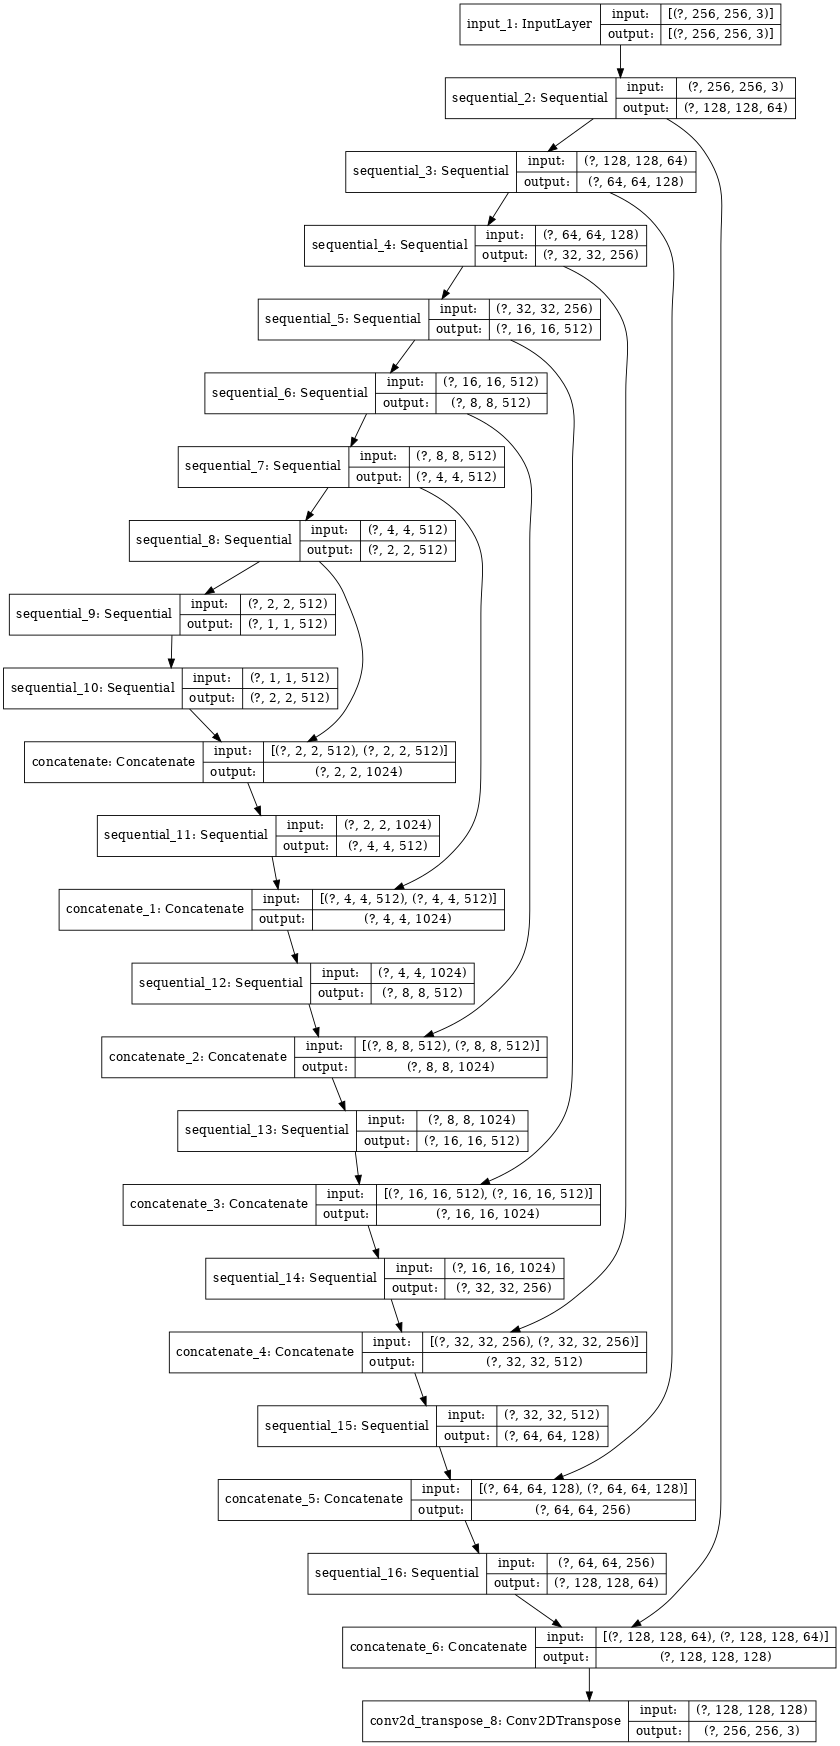

In [5]:
# Generator function defines the architecture of our Generator.
# The architecture of generator is a modified U-Net.
#   Each block in the encoder is (Conv -> Batchnorm -> Leaky ReLU)
#   Each block in the decoder is (Transposed Conv -> Batchnorm -> Dropout(applied to the first 3 blocks) -> ReLU)
#   There are skip connections between the encoder and decoder (as in U-Net).
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


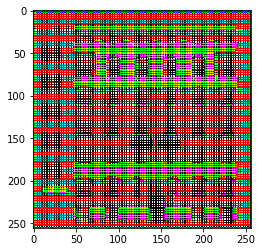

In [6]:
gen_output = generator(inp[tf.newaxis,...], training=False)
# ejemplo del output del generador
plt.imshow(gen_output[0,...])

# Generator loss


It is a sigmoid cross entropy loss of the generated images and an array of ones.
The paper also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
This allows the generated image to become structurally similar to the target image.
The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the paper.
The training procedure for the generator is shown below:

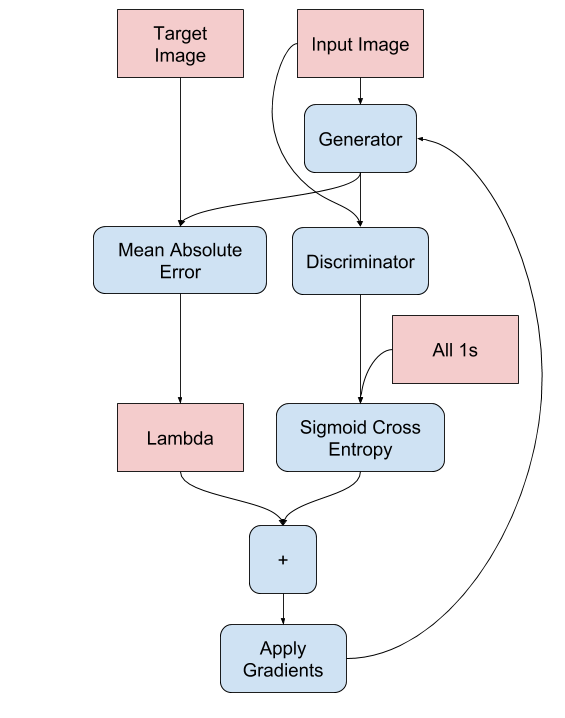

# Discriminator

**The Discriminator is a PatchGAN.**<br>
The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256x256 image to a single scalar output, which signifies "real" or "fake", whereas the PatchGAN maps from 256x256 to an NxN array of outputs X, where each X_ij signifies whether the patch ij in the image is real or fake.<br>
**Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)**<br>
**The shape of the output after the last layer is (batch_size, 30, 30, 1)**<br>

**Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).**<br>

**Discriminator receives 2 inputs.**<br>

* Input image and the target image, which it should classify as real.<br>

* Input image and the generated image (output of generator), which it should classify as fake.<br>

* We concatenate these 2 inputs together in the code (tf.concat([inp, tar], axis=-1))

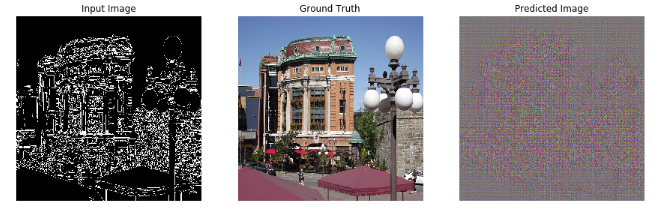<br>

 <center> **Pix2Pix inputs </center>
<img src="inputs/images/pix2pix_imputs.png" alt="drawing" width="660"/>

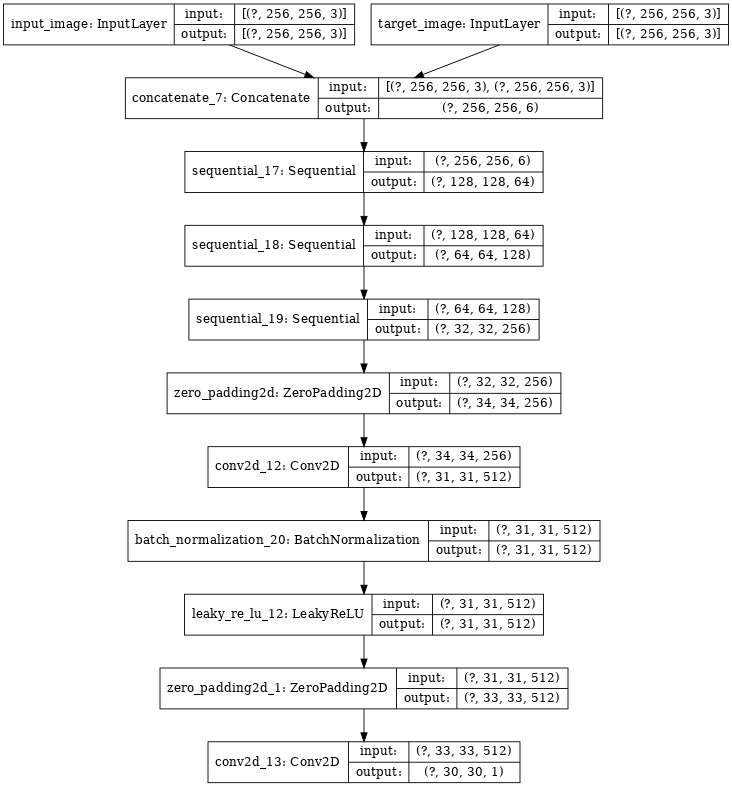

In [7]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [8]:
generator = Generator()
gen_output = generator(inp[tf.newaxis,...], training=False)

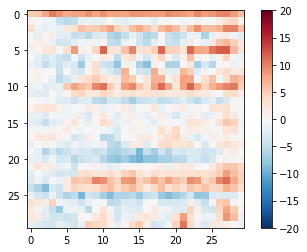

In [9]:
disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
# ejemplo del output del discriminator
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

**Discriminator loss**<br>

* The discriminator loss function takes 2 inputs; real images, generated images<br>
* real_loss is a sigmoid cross entropy loss of the real images and an array of ones(since these are the real images)<br>
* generated_loss is a sigmoid cross entropy loss of the generated images and an array of zeros(since these are the fake images)<br>
* Then the total_loss is the sum of real_loss and the generated_loss<br>

**Cross-entropy is commonly used to quantify the difference between two probability distributions. Usually the "true" distribution (the one that your machine learning algorithm is trying to match) is expressed in terms of a one-hot distribution.**

In [10]:
# Computes the cross-entropy loss between true labels and predicted labels.
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

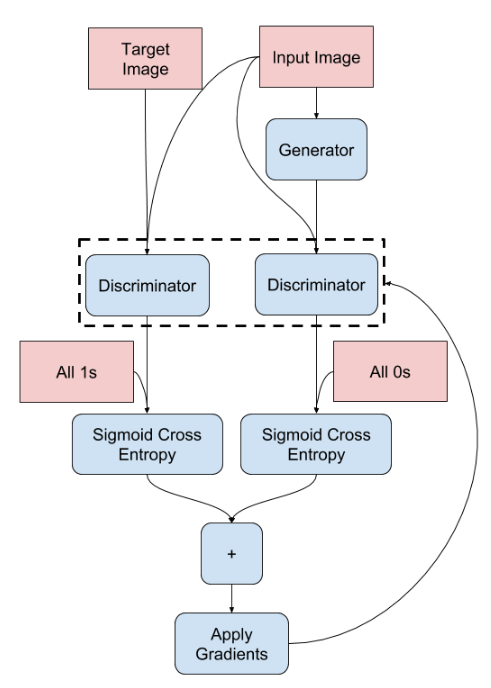